# Clustering

In [1]:
# Setup
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import os
import matplotlib.pyplot as plt
PROJECT_ROOT = ".." 
DIRS = {
    'data':    os.path.join(PROJECT_ROOT, 'outputs', 'data'),
    'models':  os.path.join(PROJECT_ROOT, 'outputs', 'models'),
    'figures': os.path.join(PROJECT_ROOT, 'outputs', 'figures'),
    'results': os.path.join(PROJECT_ROOT, 'outputs', 'results')
}

Tuning K-Means: Running Elbow Method...


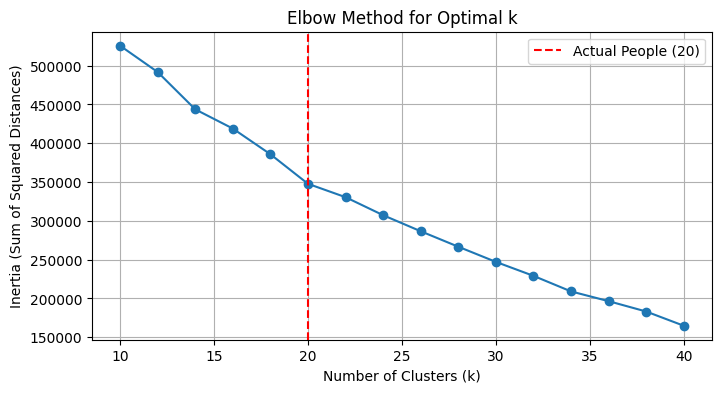

In [ ]:
Z_pca = np.load(f"{DIRS['data']}/Z_pca_test.npy")
Z_ae = np.load(f"{DIRS['data']}/Z_ae_test.npy")
y_true = np.load(f"{DIRS['data']}/y_test.npy")
# Elbow Method for K-Means
print("Tuning K-Means: Running Elbow Method...")
inertia = []
K_range = range(10, 41, 2)  # Test clusters from 10 to 40

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(Z_pca)  # Use PCA features for tuning
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.axvline(
    x=len(np.unique(y_true)),
    color="r",
    linestyle="--",
    label=f"Actual People ({len(np.unique(y_true))})",
)
plt.legend()
plt.savefig(f"{DIRS['figures']}/04_kmeans_elbow_tuning.png")
plt.show()

add this to report belove:
While the Elbow plot shows a smooth decay rather than a sharp break in the graph, we see a 'knee' region between k=18 and k=24. Since we know that we have 20 distinct individuals, we selected k=20. This value falls within the optimal range suggested by the Inertia plot while aligning with the domain knowledge of the dataset

Processed: PCA + KMeans
Processed: PCA + Hierarchical
Processed: Autoencoder + KMeans
Processed: Autoencoder + Hierarchical

--- Clustering Performance Summary ---
   Feature Set     Algorithm  ARI Score  NMI Score    Purity
0          PCA  Hierarchical   0.375957   0.724733  0.573913
1  Autoencoder  Hierarchical   0.323401   0.711973  0.556522
2          PCA        KMeans   0.328953   0.701830  0.539130
3  Autoencoder        KMeans   0.255821   0.659325  0.504348


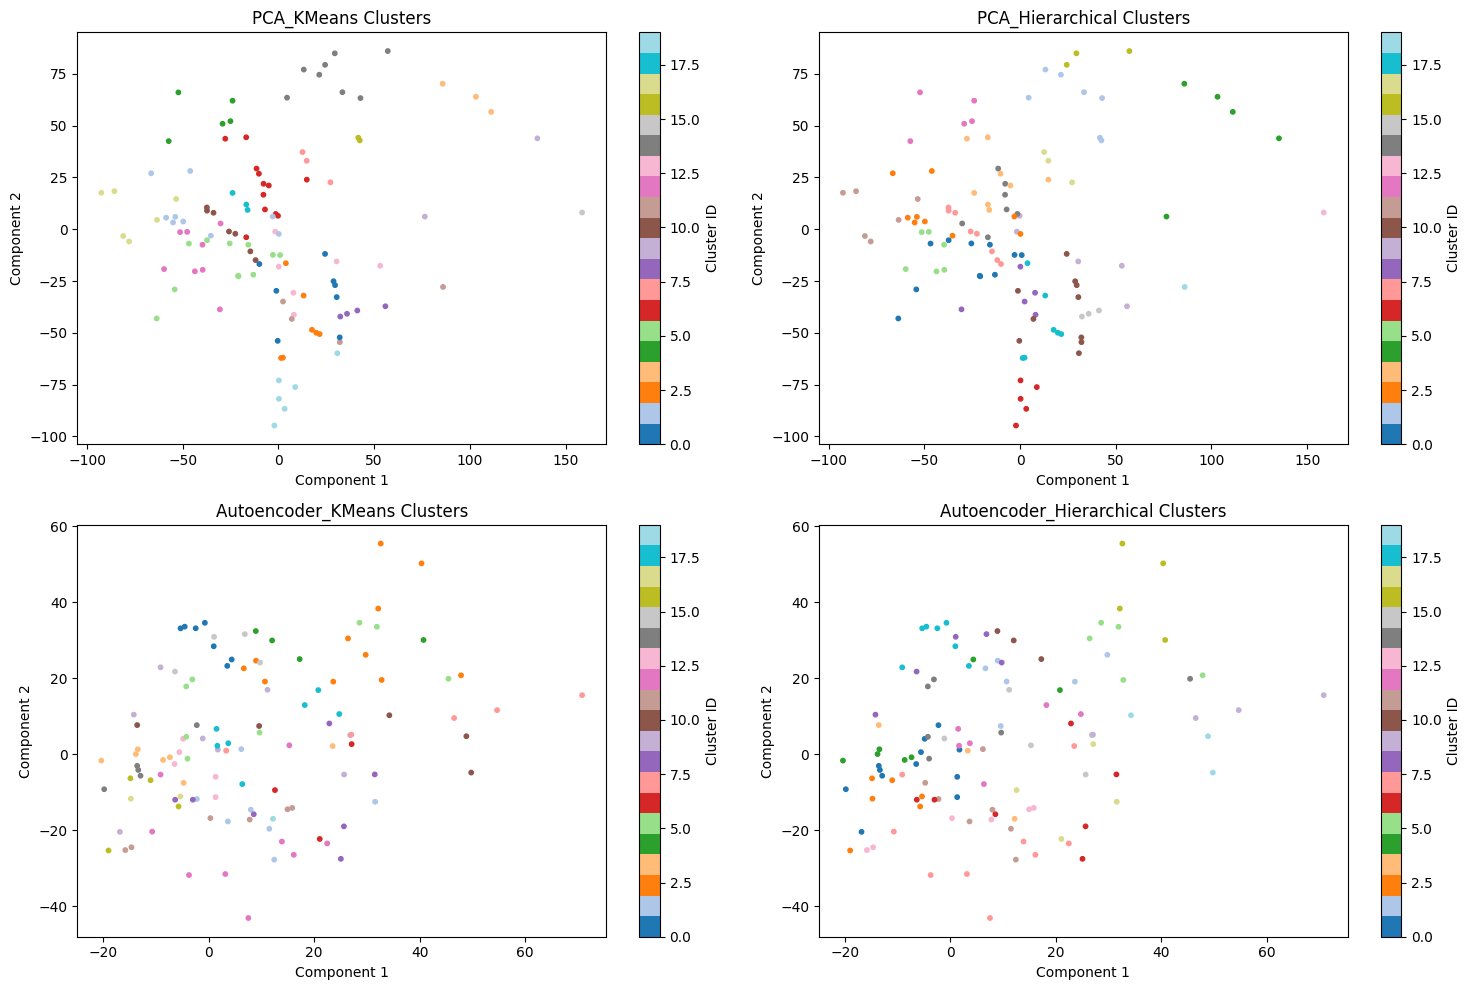

In [ ]:


# Define Purity Function
from sklearn.metrics import confusion_matrix


def purity_score(y_true, y_pred):
    # compute confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


#  Clustering & Collect Metrics
n_clusters = len(np.unique(y_true))
results = []

algorithms = {
    "KMeans": KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    "Hierarchical": AgglomerativeClustering(n_clusters=n_clusters),
}

feature_sets = {"PCA": Z_pca, "Autoencoder": Z_ae}

# store labels to plot  later
pred_labels = {}

for feat_name, X_feat in feature_sets.items():
    for algo_name, model in algorithms.items():

        labels_pred = model.fit_predict(X_feat)

        # Save for plotting
        pred_labels[f"{feat_name}_{algo_name}"] = labels_pred

        ari_score = adjusted_rand_score(y_true, labels_pred)
        nmi_score = normalized_mutual_info_score(y_true, labels_pred)
        p_score = purity_score(y_true, labels_pred)  # Calculate Purity

        results.append(
            {
                "Feature Set": feat_name,
                "Algorithm": algo_name,
                "ARI Score": ari_score,
                "NMI Score": nmi_score,
                "Purity": p_score,
            }
        )
        print(f"Processed: {feat_name} + {algo_name}")

#Save & Print Results
df = pd.DataFrame(results)
df = df.sort_values(by=["Purity", "ARI Score"], ascending=False).reset_index(drop=True)
df.to_csv(f"{DIRS['results']}/clustering_metrics.csv", index=False)

print("\n--- Clustering Performance Summary ---")
print(df)

# Visualization
plt.figure(figsize=(15, 10))

# Plot first 4 combinations
for i, (key, labels) in enumerate(pred_labels.items()):
    if i >= 4:
        break

    # Determine which data to plot (PCA vs AE)
    feat_type = key.split("_")[0]
    data = Z_pca if feat_type == "PCA" else Z_ae

    plt.subplot(2, 2, i + 1)
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab20", s=10)
    plt.title(f"{key} Clusters")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Cluster ID")

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/04_clustering_results.png")
plt.show()